# Token classification (PyTorch)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


In [2]:
import pandas as pd

train = pd.read_csv('train_preprocessed_augmented.csv', index=False)
dev = pd.read_csv('dev_preprocessed_augmented.csv', index=False)

In [23]:
train.head()

,type,tag,token
0,tweet,"[B-Appeal_to_Fear-Prejudice, I-Appeal_to_Fear-...","[تحذيرات, من, حرب, جديده, في, حال, فشل, الانتخ..."
1,tweet,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[رب, اجعل, صباحي, هذا, غائم, بلطفك, لا, شر, في..."
2,tweet,"[O, O, O, B-Name_Calling-Labeling, I-Name_Call...","[عيناليمن, سبتمبر, ثوره, شعب, صنعت, تاريخه, اح..."
3,tweet,"[O, O, O, O, B-Loaded_Language, I-Loaded_Langu...","[الحرب, على, سوريه, حملات, تظليل, مستمره, لمحا..."
4,tweet,"[O, O, O, O, O, O, O]","[مزيج, الخبره, والشباب, خلطه, سحريه, في, يورو]"


In [24]:
dev.head()

,type,tag,token
0,tweet,"[B-Doubt, I-Doubt, I-Doubt, I-Doubt, I-Doubt, ...","[هل, هذا, يعني, ان, السعوديه, تاوي, ارهابي]"
1,tweet,"[O, O, O, O, B-Name_Calling-Labeling, I-Name_C...","[المحلل, السياسي, ماجد, الخطيب, المتشددون, في,..."
2,tweet,"[B-Loaded_Language, I-Loaded_Language, I-Loade...","[التحام, من, النهر, الى, البحر, جميع, مقاهي, ج..."
3,tweet,"[B-Appeal_to_Authority, B-Questioning_the_Repu...","[موسكو, البنتاغون, تجاوز, الحد, المسموح, به, م..."
4,tweet,"[B-False_Dilemma-No_Choice, I-False_Dilemma-No...","[طهران, تتهم, تل, ابيب, بالوقوف, وراء, الهجوم,..."


In [21]:
train['tag'].iloc[0]

['B-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice',
 'B-Loaded_Language',
 'B-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice']

In [22]:
for i in range(0, 5):
    tags = train['tag'].iloc[i]
    tokens = train['token'].iloc[i]
    
    for j in range(len(tags)):
        print(f"{tokens[j]}----->{tags[j]}")
    
    print()

تحذيرات----->B-Appeal_to_Fear-Prejudice
من----->I-Appeal_to_Fear-Prejudice
حرب----->B-Loaded_Language
جديده----->B-Appeal_to_Fear-Prejudice
في----->I-Appeal_to_Fear-Prejudice
حال----->I-Appeal_to_Fear-Prejudice
فشل----->I-Appeal_to_Fear-Prejudice
الانتخابات----->I-Appeal_to_Fear-Prejudice
القادمه----->I-Appeal_to_Fear-Prejudice

رب----->O
اجعل----->O
صباحي----->O
هذا----->O
غائم----->O
بلطفك----->O
لا----->O
شر----->O
فيه----->O
ولا----->O
وقوع----->O
ولا----->O
تعثر----->O
صباحالخير----->O
العراق----->O
دعاء----->O
السومريه----->O

عيناليمن----->O
سبتمبر----->O
ثوره----->O
شعب----->B-Name_Calling-Labeling
صنعت----->I-Name_Calling-Labeling
تاريخه----->O
احتفلوا----->O
به----->O
ايه----->O
اليمانيون----->O
واذلوا----->O
انف----->B-Loaded_Language
عبيد----->I-Loaded_Language
الطغاه----->B-Name_Calling-Labeling
والامامه----->I-Name_Calling-Labeling

الحرب----->O
على----->O
سوريه----->O
حملات----->O
تظليل----->B-Loaded_Language
مستمره----->I-Loaded_Language
لمحاوله----->O
النيل----->O
من--

In [25]:
len(train['tag'].iloc[0])

9

In [26]:
len(train['token'].iloc[0])

9

In [27]:
from datasets import Dataset, DatasetDict

# Creating instances of CustomDataset for train and test sets
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(dev)

# Organizing the datasets into a dictionary-like structure
dataset_dict = DatasetDict({
    "train": train_dataset,
    "val": val_dataset
})

In [28]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['type', 'tag', 'token'],
        num_rows: 6997
    })
    val: Dataset({
        features: ['type', 'tag', 'token'],
        num_rows: 921
    })
})

In [29]:
words = dataset_dict["train"][0]["token"]
labels = dataset_dict["train"][0]["tag"]
print(len(labels))
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

9
تحذيرات                    من                         حرب               جديده                      في                         حال                        فشل                        الانتخابات                 القادمه                    
B-Appeal_to_Fear-Prejudice I-Appeal_to_Fear-Prejudice B-Loaded_Language B-Appeal_to_Fear-Prejudice I-Appeal_to_Fear-Prejudice I-Appeal_to_Fear-Prejudice I-Appeal_to_Fear-Prejudice I-Appeal_to_Fear-Prejudice I-Appeal_to_Fear-Prejudice 


In [31]:
from transformers import AutoTokenizer

model_checkpoint = "asafaya/bert-base-arabic"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [32]:
tokenizer.is_fast

True

In [33]:
inputs = tokenizer(dataset_dict["train"][0]["token"], is_split_into_words=True, truncation=True, max_length=128)
inputs.tokens()

['[CLS]',
 'تحذيرات',
 'من',
 'حرب',
 'جديده',
 'في',
 'حال',
 'فشل',
 'الانتخابات',
 'القادم',
 '##ه',
 '[SEP]']

In [34]:
inputs.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, None]

In [35]:
cls_labels = {
  'B-Appeal_to_Authority': 0,
  'I-Appeal_to_Authority': 1,
  'B-Appeal_to_Fear-Prejudice': 2,
  'I-Appeal_to_Fear-Prejudice': 3,
  'B-Appeal_to_Hypocrisy': 4,
  'I-Appeal_to_Hypocrisy': 5,
  'B-Appeal_to_Popularity': 6,
  'I-Appeal_to_Popularity': 7,
  'B-Appeal_to_Time': 8,
  'I-Appeal_to_Time': 9,
  'B-Appeal_to_Values': 10,
  'I-Appeal_to_Values': 11,
  'B-Causal_Oversimplification': 12,
  'I-Causal_Oversimplification': 13,
  'B-Consequential_Oversimplification': 14,
  'I-Consequential_Oversimplification': 15,
  'B-Conversation_Killer': 16,
  'I-Conversation_Killer': 17,
  'B-Doubt': 18,
  'I-Doubt': 19,
  'B-Exaggeration-Minimisation': 20,
  'I-Exaggeration-Minimisation': 21,
  'B-False_Dilemma-No_Choice': 22,
  'I-False_Dilemma-No_Choice': 23,
  'B-Flag_Waving': 24,
  'I-Flag_Waving': 25,
  'B-Guilt_by_Association': 26,
  'I-Guilt_by_Association': 27,
  'B-Loaded_Language': 28,
  'I-Loaded_Language': 29,
  'B-Name_Calling-Labeling': 30,
  'I-Name_Calling-Labeling': 31,
  'B-Obfuscation-Vagueness-Confusion': 32,
  'I-Obfuscation-Vagueness-Confusion': 33,
  'B-Questioning_the_Reputation': 34,
  'I-Questioning_the_Reputation': 35,
  'B-Red_Herring': 36,
  'I-Red_Herring': 37,
  'B-Repetition': 38,
  'I-Repetition': 39,
  'B-Slogans': 40,
  'I-Slogans': 41,
  'B-Straw_Man': 42,
  'I-Straw_Man': 43,
  'B-Whataboutism': 44,
  'I-Whataboutism': 45,
  'O': 46,
}

In [36]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else cls_labels[labels[word_id]]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            label = cls_labels[label]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [37]:
labels = dataset_dict["train"][0]["tag"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

['B-Appeal_to_Fear-Prejudice', 'I-Appeal_to_Fear-Prejudice', 'B-Loaded_Language', 'B-Appeal_to_Fear-Prejudice', 'I-Appeal_to_Fear-Prejudice', 'I-Appeal_to_Fear-Prejudice', 'I-Appeal_to_Fear-Prejudice', 'I-Appeal_to_Fear-Prejudice', 'I-Appeal_to_Fear-Prejudice']
[-100, 2, 3, 28, 2, 3, 3, 3, 3, 3, 4, -100]


In [38]:
word_ids

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, None]

In [39]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["token"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["tag"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [40]:
tokenized_datasets = dataset_dict.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset_dict["train"].column_names,
)

Map:   0%|          | 0/6997 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/921 [00:00<?, ? examples/s]

In [41]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

2024-05-17 04:01:43.742730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 04:01:43.742833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 04:01:43.874873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [42]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    2,    3,   28,    2,    3,    3,    3,    3,    3,    4, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100],
        [-100,   46,   46,   46,   46,   46,   46,   46,   46,   46,   46,   46,
           46,   46,   46,   46,   46,   46,   46,   46,   46,   46,   46,   46,
         -100]])

In [43]:
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

[-100, 2, 3, 28, 2, 3, 3, 3, 3, 3, 4, -100]
[-100, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, -100]


In [44]:
!pip install seqeval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=2dbee450c3b00c593092db8a76d0e058c763d4f8e16d00830cd2cacfdabe7b1a
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [45]:
import evaluate

metric = evaluate.load("seqeval")

In [46]:
labels = dataset_dict["train"][0]["tag"]
labels = [i for i in labels]
labels

['B-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice',
 'B-Loaded_Language',
 'B-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice',
 'I-Appeal_to_Fear-Prejudice']

In [47]:
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])

{'Appeal_to_Fear-Prejudice': {'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'number': 2},
 'Loaded_Language': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.8888888888888888}

In [48]:
label2id = cls_labels

In [49]:
id2label = {v: k for k, v in label2id.items()}

In [50]:
import numpy as np
from sklearn.metrics import f1_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Prepare lists for adjusted predictions and labels
    adjusted_predictions = []
    adjusted_labels = []

    # Assuming 'id2label' and 'metric' are defined and configured correctly
    for label_list, prediction_list in zip(labels, predictions):
        adjusted_label = [id2label[l] for l in label_list if l != -100]
        adjusted_pred = [id2label[p] for p, l in zip(prediction_list, label_list) if l != -100]

        # Ensure the labels and predictions are grouped by sequences
        adjusted_labels.append(adjusted_label)
        adjusted_predictions.append(adjusted_pred)

    # Compute micro and macro F1 using sklearn if necessary
    # Flatten the lists for sklearn computation
    flat_labels = [label for sublist in adjusted_labels for label in sublist]
    flat_predictions = [pred for sublist in adjusted_predictions for pred in sublist]

    # Calculate metrics using the metric module, adjust as per its requirements
    all_metrics = metric.compute(predictions=adjusted_predictions, references=adjusted_labels)
    
    return {
        "precision": all_metrics.get("overall_precision", 0),
        "recall": all_metrics.get("overall_recall", 0),
        "f1": all_metrics.get("overall_f1", 0),
        "accuracy": all_metrics.get("overall_accuracy", 0)
    }


In [51]:
id2label

{0: 'B-Appeal_to_Authority',
 1: 'I-Appeal_to_Authority',
 2: 'B-Appeal_to_Fear-Prejudice',
 3: 'I-Appeal_to_Fear-Prejudice',
 4: 'B-Appeal_to_Hypocrisy',
 5: 'I-Appeal_to_Hypocrisy',
 6: 'B-Appeal_to_Popularity',
 7: 'I-Appeal_to_Popularity',
 8: 'B-Appeal_to_Time',
 9: 'I-Appeal_to_Time',
 10: 'B-Appeal_to_Values',
 11: 'I-Appeal_to_Values',
 12: 'B-Causal_Oversimplification',
 13: 'I-Causal_Oversimplification',
 14: 'B-Consequential_Oversimplification',
 15: 'I-Consequential_Oversimplification',
 16: 'B-Conversation_Killer',
 17: 'I-Conversation_Killer',
 18: 'B-Doubt',
 19: 'I-Doubt',
 20: 'B-Exaggeration-Minimisation',
 21: 'I-Exaggeration-Minimisation',
 22: 'B-False_Dilemma-No_Choice',
 23: 'I-False_Dilemma-No_Choice',
 24: 'B-Flag_Waving',
 25: 'I-Flag_Waving',
 26: 'B-Guilt_by_Association',
 27: 'I-Guilt_by_Association',
 28: 'B-Loaded_Language',
 29: 'I-Loaded_Language',
 30: 'B-Name_Calling-Labeling',
 31: 'I-Name_Calling-Labeling',
 32: 'B-Obfuscation-Vagueness-Confusion',


In [52]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
model.config.num_labels

47

In [54]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="bert-propaganda-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Consider setting to "steps" if you want more frequent checks
    save_total_limit=1,  # Only keep the best model saved
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-6,
    num_train_epochs=15,
    weight_decay=0.001,
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="eval_loss",  # Choose the metric to use to evaluate the best model
    greater_is_better=False,  # Set to False because a lower loss is better
    push_to_hub=False,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

training_result = trainer.train()

In [56]:
import pandas as pd

log_history = trainer.state.log_history
df = pd.DataFrame(log_history)
# Filter out rows that contain evaluation metrics
df_eval = df.dropna(subset=['eval_loss'])

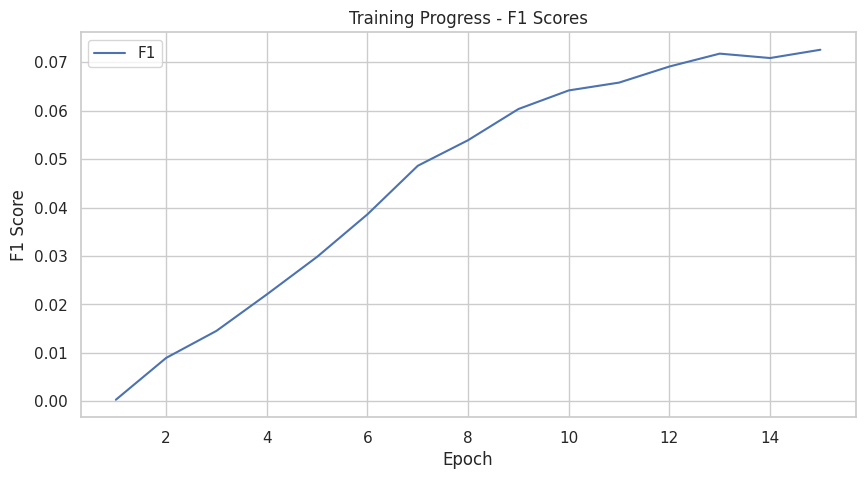

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_eval['epoch'], df_eval['eval_f1'], label='F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training Progress - F1 Scores')
plt.legend()
plt.grid(True)
plt.savefig('Training profress_F1.png', bbox_inches='tight')
plt.show()